In [177]:
import torch
import torch.nn as nn
from models import LeNet
from models_structured import PrunedLeNet, PrunedCancerNet_fc
import numpy as np
import torch 
import torchvision.transforms as transforms

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.functional import F
from models import CancerNet_fc, LeNet, ResNet
from datasets_custom import CancerDataset, RotatedMNIST
from torch.nn.utils import prune
import torchvision.transforms as transforms
from laplace import Laplace 
from laplace import KronLaplace, DiagLaplace
import torch
import time 
from utils import evaluate_classification
from marglikopt import marglik_optimization
import os
import matplotlib.pyplot as plt
import wandb
from utils import evaluate_classification
from fvcore.nn import FlopCountAnalysis



In [178]:
def get_probs(model, data_loader, device):
    all_logits = torch.tensor([]).to(device)
    all_targets = torch.tensor([], dtype=torch.long).to(device)

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model(inputs)
            all_logits = torch.cat((all_logits, logits), dim=0)
            all_targets = torch.cat((all_targets, labels), dim=0)
            
    probs = F.softmax(all_logits, dim=1)
    return probs, all_targets



def brier_score_ours(predictions, targets, num_classes):
    
    targets_one_hot = F.one_hot(targets, num_classes).to(dtype=predictions.dtype)
    

    squared_differences = (predictions - targets_one_hot) ** 2
    

    mean_squared_difference = squared_differences.mean()
    
    return mean_squared_difference


def ece_score(probs, labels, n_bins=10):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1, device=probs.device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculate ECE for each class
        for i in range(probs.shape[1]):
            in_bin = (probs[:, i] >= bin_lower) & (probs[:, i] < bin_upper)
            prop_in_bin = in_bin.float().mean()

            if prop_in_bin.item() > 0:
                avg_prob_in_bin = probs[in_bin, i].mean()
                avg_acc_in_bin = (labels[in_bin] == i).float().mean()

                ece += torch.abs(avg_acc_in_bin - avg_prob_in_bin) * prop_in_bin

    return (ece / probs.shape[1]).item() 


In [179]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [180]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=0)

In [181]:
EXPORTED_DIR ="/nfs/xxxxxx/pattern/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_struct/removed_structure_new"

In [182]:
model_data = []

In [183]:
baseline_model = LeNet()
baseline_model.load_state_dict(torch.load("/nfs/xxxxxx/pattern/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_struct/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_baseline_acc0.8630001544952393_marg_0.3875727355480194.pt"))
baseline_model.to("cuda")
baseline_model.eval()
flops = FlopCountAnalysis(baseline_model, torch.randn(1, 1, 28, 28).to("cuda"))
by_opres = flops.by_module()
# compute ece and brier score for baseline model
probs, targets = get_probs(baseline_model, valid_loader, "cuda")

brier = brier_score_ours(probs, targets, 10)

ece = ece_score(probs, targets)
# disk space
baseline_size = os.path.getsize("/nfs/xxxxxx/pattern/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_struct/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_baseline_acc0.8630001544952393_marg_0.3875727355480194.pt")

print("ece baseline", ece)
print("brier baseline", brier)

model_data.append({"sparsity":0, "accuracy": 86.300,  "flops": flops.total(),"marglik":0.3875727355480194,"by_opres":by_opres,"ece":ece, "brier":brier.item(), "size":baseline_size})

Unsupported operator aten::max_pool2d encountered 2 time(s)


ece baseline 0.007544141262769699
brier baseline tensor(0.0193, device='cuda:0')


In [184]:



for model_name in os.listdir(EXPORTED_DIR):
    if model_name.endswith('.pt'):
        print(model_name)
        sp = int(model_name.split("_")[4])
        acc = float(model_name.split("_")[6])
        marg = float(model_name.split("_")[8].strip(".pt"))
        model_meta = torch.load(os.path.join(EXPORTED_DIR, model_name))["metadata"]

        # Create and load model (assuming PrunedCancerNet_fc is defined elsewhere)
        new_model = PrunedLeNet(
            n_filters_conv1=model_meta['n_filters_conv1'],
            n_filters_conv2=model_meta['n_filters_conv2'],
            n_filters_conv3=model_meta['n_filters_conv3']
        )
        new_model.load_state_dict(torch.load(os.path.join(EXPORTED_DIR, model_name))["state_dict"])
        new_model.to("cuda")
        new_model.eval()
        probs, targets = get_probs(new_model, valid_loader, "cuda")
        brier = brier_score_ours(probs, targets, 10).item()
        ece = ece_score(probs, targets,10)
        disk_size = os.path.getsize(os.path.join(EXPORTED_DIR, model_name))
        print(brier)
        print(ece)
        
        # Calculate FLOPs
        flops = FlopCountAnalysis(new_model, torch.randn(1, 1,28,28).to("cuda")).total()
        mod = FlopCountAnalysis(new_model, torch.randn(1, 1,28,28).to("cuda")).by_module()
    

        # Collect data
        model_data.append({'sparsity': sp, 'accuracy': acc, 'flops': flops, "marglik":marg, "by_opres":mod, "ece":ece, "brier":brier,"size":disk_size})



LeNet_FashionMnist_KronLaplace_diagonalreducued_90_acc_81.00001215934753_marg_0.5398586392402649.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.026538904756307602
0.006629978306591511
LeNet_FashionMnist_KronLaplace_diagonalreducued_60_acc_86.08002662658691_marg_0.4352536201477051.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.019583964720368385
0.006920791696757078
LeNet_FashionMnist_KronLaplace_diagonalreducued_70_acc_85.20001173019409_marg_0.4518905580043793.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.020687436684966087
0.006720718927681446
LeNet_FashionMnist_KronLaplace_diagonalreducued_99_acc_68.23999285697937_marg_0.8606677055358887.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.04319024458527565
0.009574460797011852
LeNet_FashionMnist_KronLaplace_diagonalreducued_20_acc_87.69002556800842_marg_0.42162150144577026.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.01778324320912361
0.0071145715191960335
LeNet_FashionMnist_KronLaplace_diagonalreducued_95_acc_77.86997556686401_marg_0.6255322694778442.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.030619515106081963
0.010137107223272324
LeNet_FashionMnist_KronLaplace_diagonalreducued_85_acc_83.40001106262207_marg_0.4780082106590271.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.02318410575389862
0.006063021253794432
LeNet_FashionMnist_KronLaplace_diagonalreducued_80_acc_84.3000054359436_marg_0.4559093117713928.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.021761389449238777
0.006230300758033991
LeNet_FashionMnist_KronLaplace_diagonalreducued_75_acc_85.07999181747437_marg_0.4486382007598877.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.021198103204369545
0.004252636805176735
LeNet_FashionMnist_KronLaplace_diagonalreducued_40_acc_87.69999146461487_marg_0.4084223210811615.pt


Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


0.017709210515022278
0.007184239570051432


In [185]:
unstructured_perf = [ 
    89.24749999999999, 89.24374999999999, 89.26875000000001, 89.27249999999998, 
    89.25875, 89.225, 89.1675, 89.08874999999999, 87.97749999999999, 26.61375
]
flops_unstructured = [ 231720 ] * len(unstructured_perf)

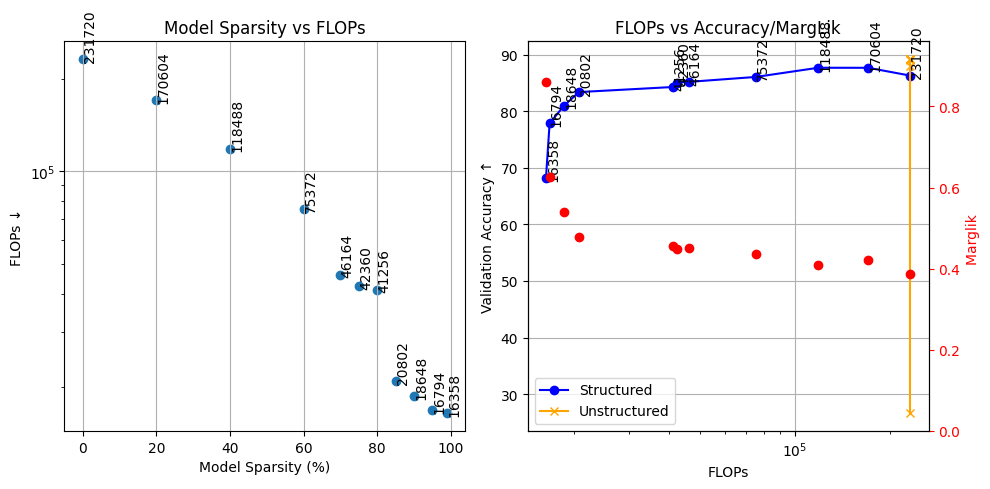

In [186]:
# Separate the data for plotting
sparsities = [d['sparsity'] for d in model_data]
accuracies = [d['accuracy'] for d in model_data]
flops = [d['flops'] for d in model_data]
marg = [d['marglik'] for d in model_data]
brier = [d['brier'] for d in model_data] 
ece =  [d['ece'] for d in model_data] 
disk_size = [d['size'] for d in model_data]

# Sort the data by flops
sorted_data = sorted(zip(flops, sparsities, accuracies, marg, brier, ece, disk_size))

# Unzip the sorted data
sorted_flops, sorted_sparsities, sorted_accuracies, sorted_marg, sorted_brier, sorted_ece, disk_size = zip(*sorted_data)

# Plot Sparsity vs FLOPs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(sorted_sparsities, sorted_flops)

# add text for each point
for i, txt in enumerate(sorted_flops):
    # reverse the text for better readability
    plt.annotate(txt, (sorted_sparsities[i], sorted_flops[i]), rotation=90)
    
plt.xlabel('Model Sparsity (%)')
plt.ylabel('FLOPs \u2193')
plt.grid(True)
plt.title('Model Sparsity vs FLOPs')
plt.yscale('log')

# Plot FLOPs vs Accuracy
plt.subplot(1, 2, 2)
plt.plot(sorted_flops, sorted_accuracies, color='blue', marker='o', label='Structured')
plt.plot(flops_unstructured, unstructured_perf, color='orange', marker='x', label='Unstructured')
plt.legend()

# add text for each point
for i, txt in enumerate(sorted_flops):
    plt.annotate(txt, (sorted_flops[i], sorted_accuracies[i]), rotation=90)
    
plt.xlabel('FLOPs')
plt.ylabel('Validation Accuracy \u2191')
plt.grid(True)
plt.title('FLOPs vs Accuracy/MargLik')
ax3 = plt.twinx()
ax3.scatter(sorted_flops, sorted_marg, color='red')
ax3.set_ylabel('Marglik ', color='red')
ax3.tick_params(axis='y', colors='red')
ax3.set_ylim([0, max(sorted_marg) + 0.1])
plt.xscale('log')
plt.tight_layout()
plt.savefig("Lenet_flops_vs_acc_tue_z.pdf")
plt.show()
#ge


In [187]:
import math

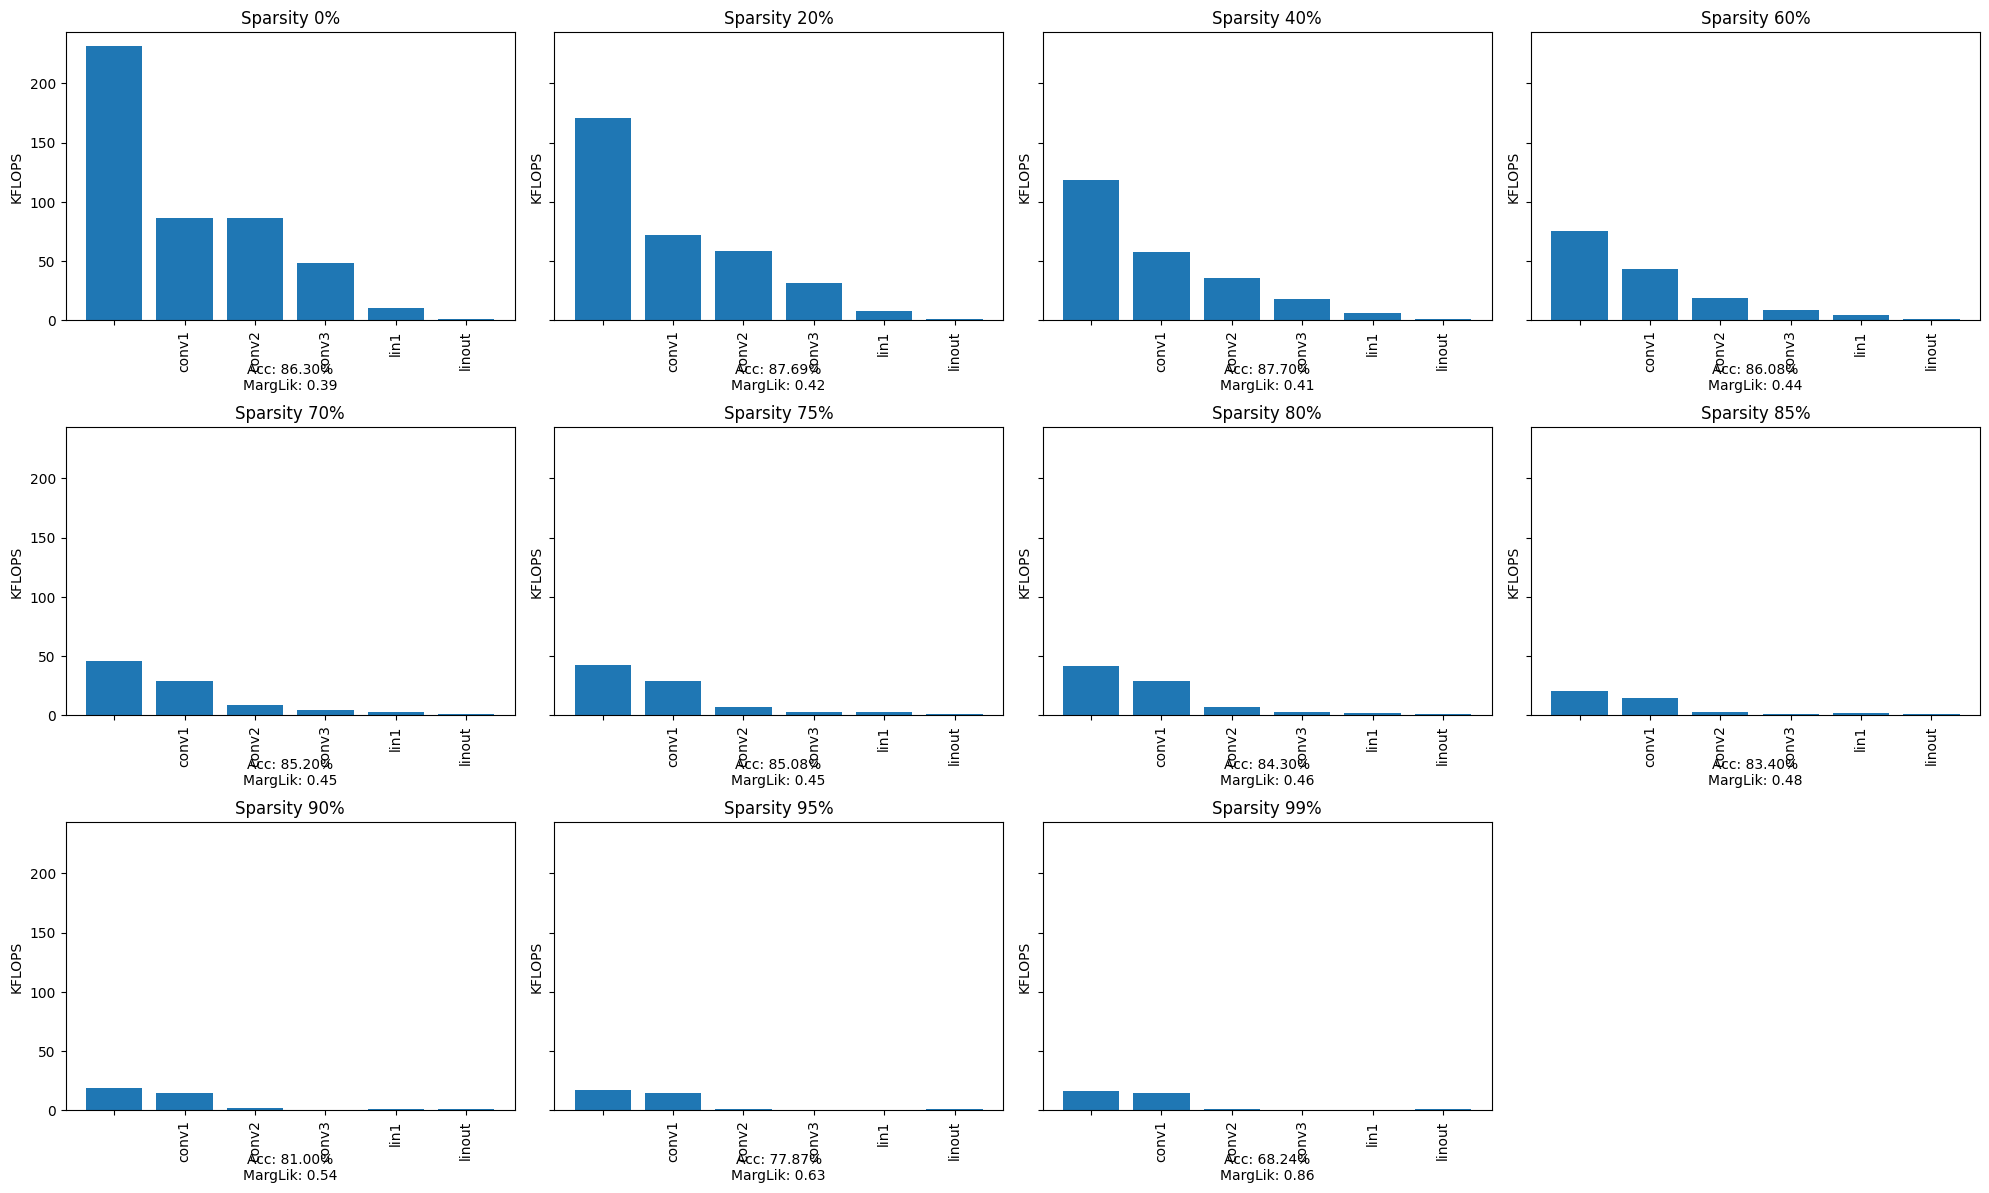

In [188]:
# Assuming model_data is already populated with the necessary data
model_data = sorted(model_data, key=lambda x: x['sparsity'])  # Sorting data by sparsity

# Determine the number of subplots and layout (square-ish layout)
n_subplots = len(model_data)
n_cols = math.ceil(math.sqrt(n_subplots))
n_rows = math.ceil(n_subplots / n_cols)

# Create a figure with multiple subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharey=True)  # Adjust figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

for i, model_info in enumerate(model_data):
    # Data for the current model
    modules = list(model_info["by_opres"].keys())
    flops = [flop / 1e3 for flop in model_info["by_opres"].values()]  # Convert FLOPS to GFLOPS

    # Skip zero values
    modules, flops = zip(*[(mod, flop) for mod, flop in zip(modules, flops) if flop > 0])

    # Plotting
    axs[i].bar(modules, flops)
    axs[i].set_title(f"Sparsity {model_info['sparsity']}%")  # Format sparsity to two decimal places
    axs[i].set_ylabel('KFLOPS')
    
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Additional information as text
    axs[i].text(0.5, -0.2, f"Acc: {model_info['accuracy']:.2f}%\nMargLik: {model_info['marglik']:.2f}",
                horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)

# Adjust layout and save to PDF
# turn of last  the last ax if there are odd number of subplots
if n_subplots % 2 == 1:
    axs[-1].axis('off')
 
plt.tight_layout()
plt.savefig('model_flops_analysis.pdf', format='pdf')

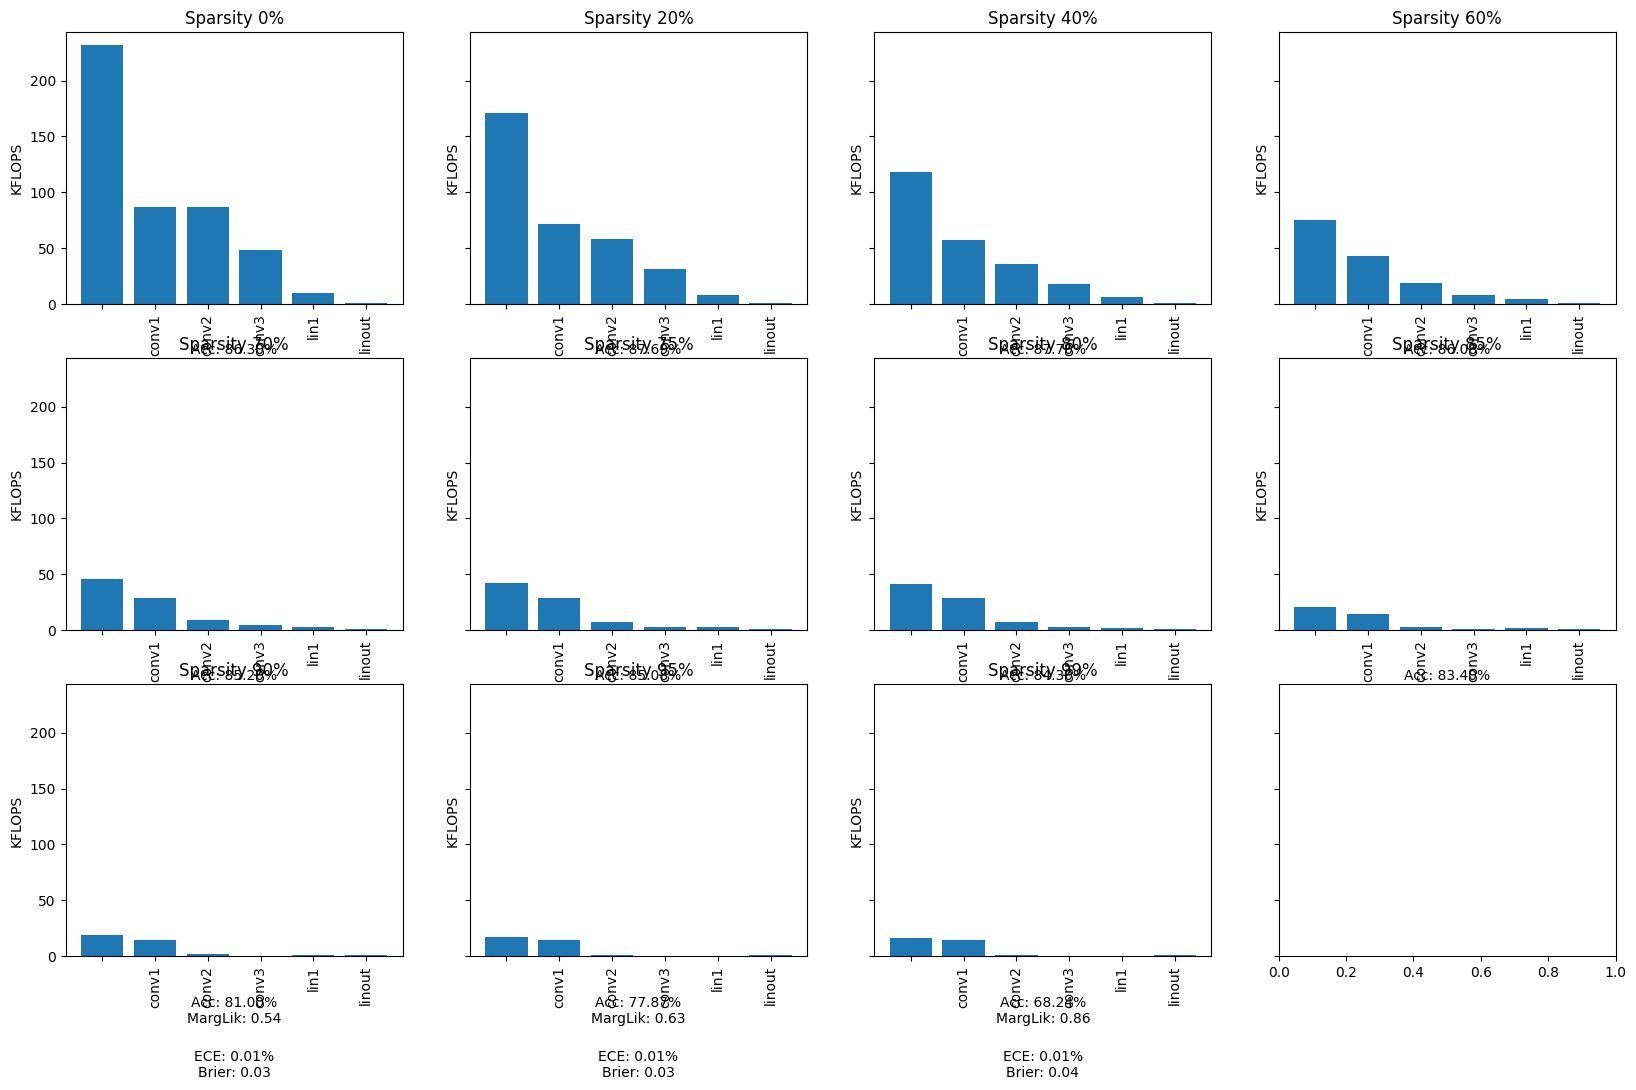

In [195]:
# brier score and ece plots 
model_data = sorted(model_data, key=lambda x: x['sparsity'])

# Determine the number of subplots and layout (square-ish layout)
n_subplots = len(model_data)
n_cols = math.ceil(math.sqrt(n_subplots))
n_rows = math.ceil(n_subplots / n_cols)

# Create a figure with multiple subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharey=True)  # Adjust figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

for i, model_info in enumerate(model_data):
    # Data for the current model
    modules = list(model_info["by_opres"].keys())
    flops = [flop / 1e3 for flop in model_info["by_opres"].values()]  # Convert FLOPS to GFLOPS

    # Skip zero values
    modules, flops = zip(*[(mod, flop) for mod, flop in zip(modules, flops) if flop > 0])

    # Plotting
    axs[i].bar(modules, flops)
    axs[i].set_title(f"Sparsity {model_info['sparsity']}%")  # Format sparsity to two decimal places
    axs[i].set_ylabel('KFLOPS')
    
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Additional information as text
    axs[i].text(0.5, -0.2, f"Acc: {model_info['accuracy']:.2f}%\nMargLik: {model_info['marglik']:.2f}",
                horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    
    axs[i].text(0.5, -0.4, f"ECE: {model_info['ece']:.2f}%\nBrier: {model_info['brier']:.2f}",
                horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    

In [196]:
sorted_brier

(0.04319024458527565,
 0.030619515106081963,
 0.026538904756307602,
 0.02318410575389862,
 0.021761389449238777,
 0.021198103204369545,
 0.020687436684966087,
 0.019583964720368385,
 0.017709210515022278,
 0.01778324320912361,
 0.019326528534293175)

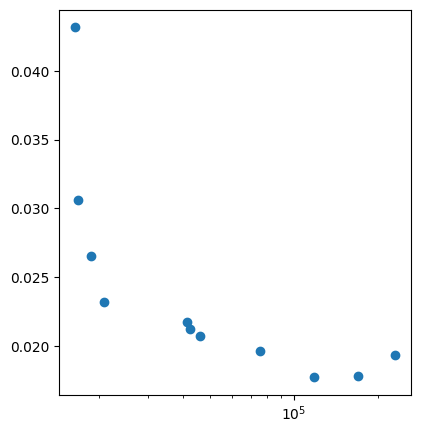

In [197]:
# Assuming model_data contains the necessary information
# and flops_unstructured, unstructured_perf are also available as mentioned
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.scatter( sorted_flops,sorted_brier)




In [198]:
# export the data to csv file
import pandas as pd
df = pd.DataFrame(model_data)
df.to_csv("Lenet_flops_analysis_make_tue.csv")

In [199]:
df = pd.read_csv("Lenet_flops_analysis_make_tue.csv")

In [200]:
df.head()

,Unnamed: 0,sparsity,accuracy,flops,marglik,by_opres,ece,brier,size
0,0,0,86.300000,231720,0.387573,"Counter({'': 231720, 'conv1': 86400, 'conv2': ...",0.007544,0.019327,246063
1,1,20,87.690026,170604,0.421622,"Counter({'': 170604, 'conv1': 72000, 'conv2': ...",0.007115,0.017783,169471
2,2,40,87.699991,118488,0.408422,"Counter({'': 118488, 'conv1': 57600, 'conv2': ...",0.007184,0.017709,107443
3,3,60,86.080027,75372,0.435254,"Counter({'': 75372, 'conv1': 43200, 'conv2': 1...",0.006921,0.019584,60147
4,4,70,85.200012,46164,0.451891,"Counter({'': 46164, 'conv1': 28800, 'conv2': 9...",0.006721,0.020687,39923


In [208]:
# directory of the unstructured models to compute the brier score and ece
EXPORTED_DIR ="/nfs/xxxxxx/inference/LeNet_FashionMnist_DiagLaplace_diagonal_100_wp/laplacekron_brier"

model_data = []
# copy the baseline model from the structured models
baseline_model = LeNet()
baseline_model.load_state_dict(torch.load("/nfs/xxxxxx/pattern/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_struct/LeNet_FashionMnist_KronLaplace_diagonal_100_wp_baseline_acc0.8630001544952393_marg_0.3875727355480194.pt"))
baseline_model.to("cuda")

# compute ece and brier score for baseline model
probs, targets = get_probs(baseline_model, valid_loader, "cuda")

brier = brier_score_ours(probs, targets, 10)

ece = ece_score(probs, targets)
# skip disk and flops 
model_data.append({"sparsity":0, "accuracy": 86.300,  "flops": 0,"marglik":0.3875727355480194,"by_opres":0,"ece":ece, "brier":brier.item()})

# loop over the unstructured models

for model_name in os.listdir(EXPORTED_DIR):
    if model_name.endswith('.pt'):
        print(model_name)
        sp = int(model_name.split("_")[2])
        acc = float(model_name.split("_")[4])
        marg = float(model_name.split("_")[6].strip(".pt"))
        model_meta = torch.load(os.path.join(EXPORTED_DIR, model_name))

        # Create and load model (assuming PrunedCancerNet_fc is defined elsewhere)
        new_model = LeNet()
        new_model.load_state_dict(torch.load(os.path.join(EXPORTED_DIR, model_name)))
        new_model.to("cuda")
        new_model.eval()
        probs, targets = get_probs(new_model, valid_loader, "cuda")
        brier = brier_score_ours(probs, targets, 10).item()
        ece = ece_score(probs, targets,10)
        print(brier)
        print(ece)
        
        # Calculate FLOPs
        flops = 0
    

        # Collect data
        model_data.append({'sparsity': sp, 'accuracy': acc, 'flops': flops, "marglik":marg, "by_opres":0, "ece":ece, "brier":brier})


LeNet_sp_95_acc_55.11_marg_0.46749839186668396.pt
0.057512711733579636
0.05573968216776848
LeNet_sp_20_acc_87.82_marg_0.45488905906677246.pt
0.017175836488604546
0.009000579826533794
LeNet_sp_60_acc_86.04_marg_0.4649961590766907.pt
0.02000347524881363
0.010453179478645325
LeNet_sp_75_acc_78.27_marg_0.46072936058044434.pt
0.03197464346885681
0.03105548955500126
LeNet_sp_99_acc_18.12_marg_0.4208419620990753.pt
0.11191883683204651
0.1300554722547531
LeNet_sp_40_acc_87.73_marg_0.4502470791339874.pt
0.017896123230457306
0.008286465890705585
LeNet_sp_90_acc_72.67_marg_0.46091288328170776.pt
0.037595391273498535
0.03910980001091957
LeNet_sp_80_acc_79.54_marg_0.4801613390445709.pt
0.029878385365009308
0.024435194209218025
LeNet_sp_85_acc_75.56_marg_0.4652405083179474.pt
0.034728262573480606
0.03317086026072502
LeNet_sp_70_acc_81.88_marg_0.4810538589954376.pt
0.02611197903752327
0.019402889534831047


In [210]:
df = pd.DataFrame(model_data)
df.to_csv("unstructured_lenet_analysis.csv")